# Fitting the Low-Rank plus Sparse estimator in R

*Note*: These functions and more will soon be available as part of an R package on CRAN.
In the meantime, this tutorial shows, in order, how to: 
* 1) fit the estimator for a given value of the tuning parameters
* 2) fit a whole path
* 3) perform cross-validation
* 4) use a robust estimator of the correlation matrix based on Kendall correlations.

Questions or remarks? : benjamin dot frot @ gmail dot com

## Required packages

The following packages (all available on CRAN) are required to run the code (fit the estimator etc...)

In [101]:
packages <- c("Matrix", "MASS", "mvtnorm", "RSpectra", "matrixcalc", "pcaPP", "cvTools")
install.packages(packages)
for (pkg in packages)
    eval(paste("library(", pkg, ")"))


The downloaded binary packages are in
	/var/folders/d7/dhbt8tyd3ksf__y96t051n100000gn/T//RtmpM5NVQY/downloaded_packages


The following additional packages are used in this notebook:

In [8]:
packages <- c("ggplot2")
install.packages(packages)
library(ggplot2)
library(reshape2)

library(repr)
options(repr.plot.width=4, repr.plot.height=4)


The downloaded binary packages are in
	/var/folders/d7/dhbt8tyd3ksf__y96t051n100000gn/T//RtmpM5NVQY/downloaded_packages


## Fitting the estimator for a given value of the tuning parameters

Recall that given an $n \times p$ data matrix $X$ constiting of $n$ realisations of a random vector $x \in \mathbb{R}^p \sim \mathcal{N}(0, \Sigma)$, the so-called "Low-rank plus Sparse" (LRpS) estimator defined in https://projecteuclid.org/euclid.aos/1351602527 optimises the following function:
$$
  (\hat{S} , \hat{L}) = \arg \min_{S - L \succ 0, L \succeq 0} - \log\det (S - L) + 
  Tr((S - L)\hat{\Sigma}) + \lambda (\gamma ||S||_1 + (1 - \gamma)Tr(L) ),
$$
where $\hat{\Sigma}$ is some estimator of $\Sigma$ (typically the sample covariance matrix), $\lambda > 0$ and $\gamma \in (0, 1)$ are tuning parameters.

We implement the algorithm with restarts described here: ftp://ftp.math.ucla.edu/pub/camreport/cam12-35.pdf

### Generate some data

Let us start by generating some synthetic data we can fit the estimator to.

In [117]:
p <- 100 # Number of obvserved variables 
h <- 3 # Number of hidden variables
n <- 2000 # Number of samples
set.seed(0)
source("./utils//simulate_data.R")
toy.data <- simulate.latent.ggm.data(n = n, p = p, h = h, outlier.fraction = 0.0) # Data from a multivariate normal
X <- toy.data$obs.data # The observed data
X <- scale(X)
# The true sparse matrix we try to estimate
true.S <- toy.data$true.precision.matrix[1:p,1:p]
# Let us keep only the non-diagonal entries
true.S <- 1 * ((true.S - diag(diag(true.S))) != 0)

Let us see what the sparse matrix we try to estimate looks like

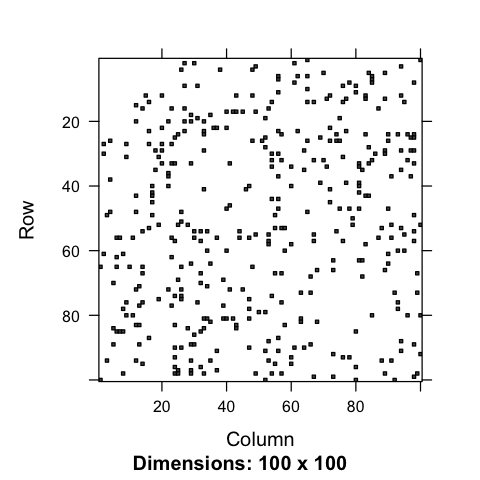

In [118]:
image(Matrix(true.S, sparse = T))

### Fit the estimator

[1] "Term Msg: Convergence reached."
[1] "Number of iterations: 30"
[1] "Precision: 0.9 Recall: 0.139896373056995"
[1] "Rank of L: 3"


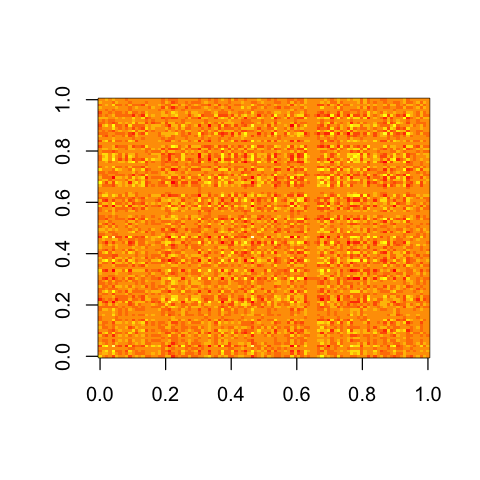

In [123]:
source("./lrps/fast_lrps_admm.R")
Sigma <- cor(X) # The sample correlation matrix

# Some reasonable values of the tuning parameters
lambda <- 0.55
gamma <- 0.15 # A small value of gamma favours an L with a small rank.
lam1 <- lambda * gamma
lam2 <- lambda * (1 - gamma)

fit <- fit.low.rank.plus.sparse(Sigma = Sigma, Lambda1 = lam1, Lambda2 = lam2, n = nrow(X), 
                                tol = 1e-07, print_progress = TRUE)
print(paste("Term Msg:", fit$termmsg))
print(paste("Number of iterations:", fit$iter))

# Let us get the parameters we fitted
S <- fit$S # The estimated Shat
Sbin <- 1 * ((fit$S - diag(diag(fit$S))) !=0)
L <- fit$L

# Let us see what the precision and recall are for the recovery of S
recall <- sum(Sbin * true.S) / sum(true.S)
precision <- sum(Sbin * true.S) / sum(Sbin)
print(paste("Precision:", precision, "Recall:", recall))
print(paste("Rank of L:", sum(eigen(L)$val > 1e-6)))

# Let us look at the low-rank matrix L
image(L)

## Fit a whole path

Since we use the "warm-starts" (*i.e.* resuse the value of the previous fit), we can also fit a whole regularisation path for a given value of $\gamma$. 

One can provide their own sequence of lambdas, or let the program choose `n.lambdas` within a reasonable range. 
The default is a geometric sequence of `n.lambdas` values, ranging from `lambda.max` to `lambda.ratio * lambda.max`.
Since it does not make much sense to have a very dense $S$, the function stops computing the path when $S$ reaches a sparsity of `max.sparsity` (default 0.5). Likewise, if the rank of $L$ is greater than `max.rank`, we stop (default min(n-1, p-1)).

[1] "Length of the path 17"


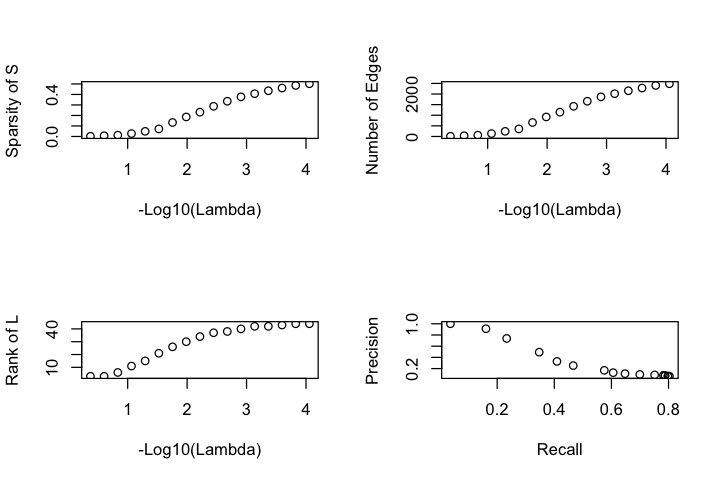

In [159]:
source("./lrps/fit_path.R")
lrps.path <- fit.low.rank.plus.sparse.path(Sigma = Sigma, gamma = 0.15, n = nrow(X), n.lambdas = 40,
                                           lambda.ratio = 1e-04, tol=1e-07)
# The output is a list, one per value of lambda
print(paste("Length of the path", length(lrps.path)))
# There is a function to show the basic properties of the path.
options(repr.plot.width=6, repr.plot.height=4)
show.low.rank.plus.sparse.path(lrps.path, ground.truth = true.S)

[1] "Rank of L 3"


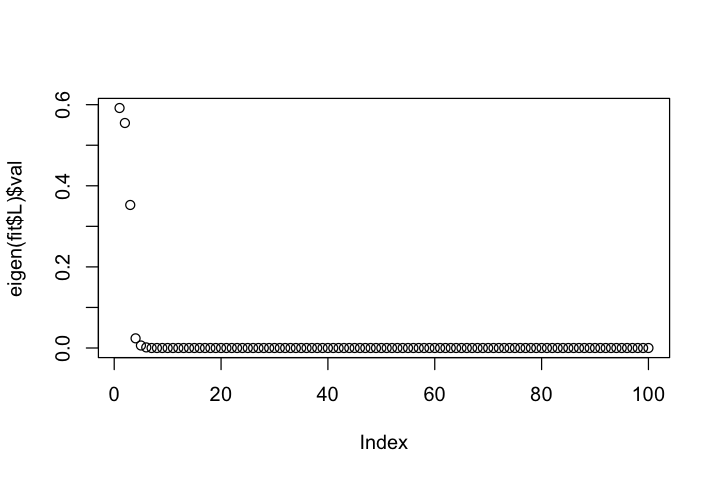

In [160]:
# Here is how to access the fit associated with the 2rd value of lambda (for example)
fit <- lrps.path[[3]]$fit
print(paste("Rank of L", lrps.path[[2]]$rank.L))
# The spectrum of L
plot(eigen(fit$L)$val)

## Performing cross-validation

In order to pick $\lambda$ (and possiby $\gamma$) one can perform cross-validation.

Here, we perform 5-fold cross-validation for a given value of $\gamma$. The function first computes a path in order to estimate which values of $\lambda$ are reasonable. It then performs cross-validaion.

In [150]:
source("./lrps/cross_validation.R")
xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.15, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = TRUE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)

[1] "### Computing the path on the full dataset first ###"
[1] "Fitting with gamma= 0.15  and lambda= 0.688344311963032 Sparsity: 0.000202020202020202 Rank of L: 2"
[1] "Fitting with gamma= 0.15  and lambda= 0.5791695598648 Sparsity: 0.00323232323232323 Rank of L: 3"
[1] "Fitting with gamma= 0.15  and lambda= 0.487310453859029 Sparsity: 0.00848484848484849 Rank of L: 3"
[1] "Fitting with gamma= 0.15  and lambda= 0.410020648349902 Sparsity: 0.0133333333333333 Rank of L: 6"
[1] "Fitting with gamma= 0.15  and lambda= 0.34498938149582 Sparsity: 0.0246464646464646 Rank of L: 11"
[1] "Fitting with gamma= 0.15  and lambda= 0.290272389509764 Sparsity: 0.0412121212121212 Rank of L: 15"
[1] "Fitting with gamma= 0.15  and lambda= 0.244233778287257 Sparsity: 0.0565656565656566 Rank of L: 18"
[1] "Fitting with gamma= 0.15  and lambda= 0.205497114476548 Sparsity: 0.0911111111111111 Rank of L: 21"
[1] "Fitting with gamma= 0.15  and lambda= 0.172904273742674 Sparsity: 0.114545454545455 Rank of L: 26"


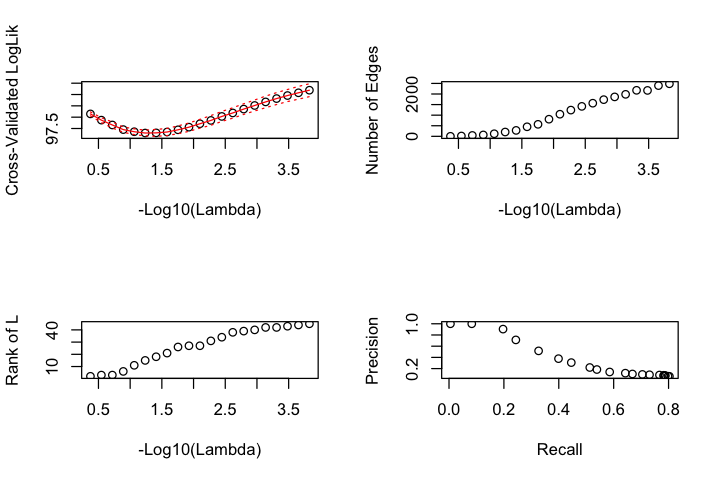

In [158]:
# There is also a function to show the cross-validated path.
show.cross.validate.low.rank.plus.sparse(xval.path, ground.truth = true.S) # The ground truth is optional

In [164]:
# We can pick the best graph according to cross-validation according to two criteria
best.fit <- choose.cross.validate.low.rank.plus.sparse(xval.path = xval.path)
print(paste("Sparsity:", best.fit$sparsity))
# This one typically picks a more parsimonious models
best.fit.hastie <- choose.cross.validate.low.rank.plus.sparse(xval.path = xval.path, method = "hastie")
print(paste("Sparsity:", best.fit.hastie$sparsity))

[1] "Sparsity: 0.0412121212121212"
[1] "Sparsity: 0.0246464646464646"


We can compare the outcome of the cross-validation selection procedure for those two criteria:

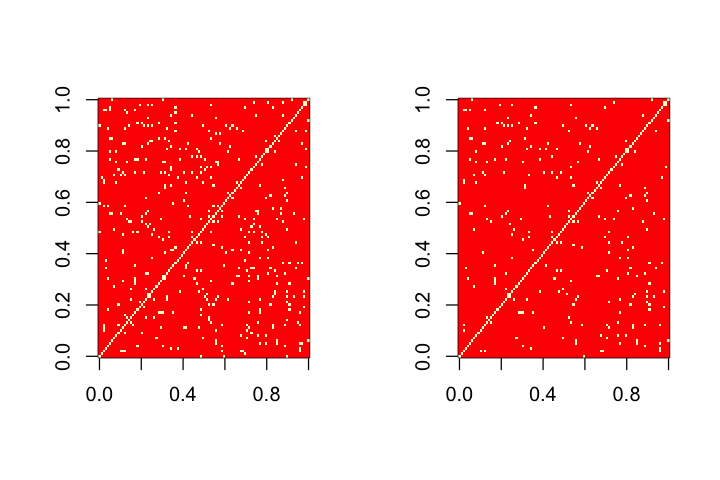

In [162]:
par(mfrow=c(1,2))
image(Matrix(best.fit$fit$S!=0, sparse=T))
image(Matrix(best.fit.hastie$fit$S!=0, sparse=T))
par(mfrow = c(1,1))

Now, let us perform cross-validation for a number of values of $\gamma$ and pick the best. Ideally we shoould account for the standard deviation in the cross-validated loglikelihoods.

*Note that if you want to be able to compare the cross-validated values for different values of $\gamma$, you must set the seed parameter. Otherwise, we cannot compare the output of two runs of the function.*

[1] 0.05
[1] 0.07
[1] 0.1
[1] 0.12
[1] 0.15
[1] 0.17
[1] 0.2
[1] 0.25


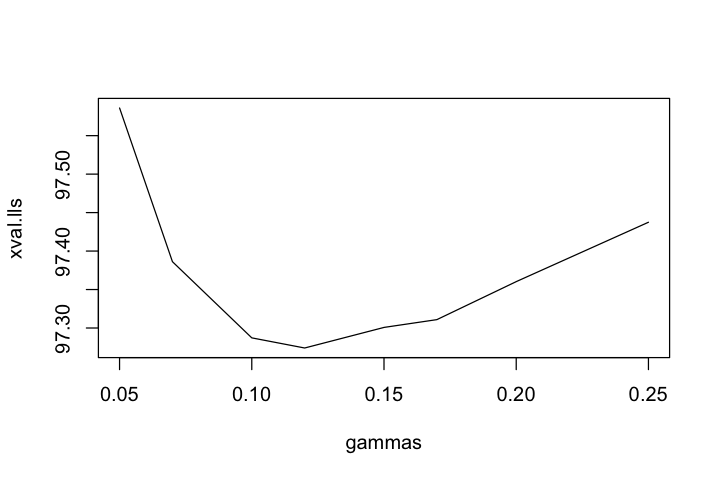

In [205]:
xval.lls <- c()
gammas <- c(0.05, 0.07, 0.1, 0.12, 0.15, 0.17, 0.2, 0.25)
for(gamma in gammas) {
    xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = gamma, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)
    bf <- choose.cross.validate.low.rank.plus.sparse(xval.path)$mean_xval_ll
    xval.lls <- c(xval.lls, bf)
}
plot(gammas, xval.lls, type='l')

It looks like cross-validation selects a value of 0.12. Recall that cross-validation tends to *overselcts*. The ideal parameters for $\lambda$ and $\gamma$ probably lead to a more parsimonious model.

In [204]:
xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.12, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)
bf <- choose.cross.validate.low.rank.plus.sparse(xval.path)
print(paste(bf$lambda, bf$number.of.edges, bf$sparsity, bf$rank.L))

[1] "0.305292222859071 436 0.0880808080808081 11"


## Dealing with outliers: Using a robust estimator of the covariance.

Finally, we generate some data with outliers and use an estimator of the covariance matrix which is based on a modified version of the Kendall correlation matrix

In [206]:
# Let us generate data with outliers
p <- 100 # Number of obvserved variables 
h <- 3 # Number of hidden variables
n <- 2000 # Number of samples
set.seed(0)
source("./utils//simulate_data.R")
toy.data <- simulate.latent.ggm.data(n = n, p = p, h = h, outlier.fraction = 0.1) # 10% are outliers (Cauchy)
X <- toy.data$obs.data # The observed data
X <- scale(X)
# The true sparse matrix we try to estimate
true.S <- toy.data$true.precision.matrix[1:p,1:p]
# Let us keep only the non-diagonal entries
true.S <- 1 * ((true.S - diag(diag(true.S))) != 0)

In [207]:
# Fit the path with the sample correlation matrix
xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.12, n = nrow(X), covariance.estimator = cor, 
                                                 n.folds = 5, 
                                                 verbose = FALSE, seed = 1,
                                                 n.lambdas = 40, lambda.ratio = 1e-03)

Warning message in .split.bregman.low.rank.plus.sparse.update.parameters(parameters, :
“The accelerated ADMM algorithm restarted 100 times in a row. It seems like the required convergence tolerance cannot be achieved. This might due to the problem being too ill-posed. For example, the value of gamma might be too large given the ratio p/n. You might also want to consider trying a smaller value of mu.
”Warning message in .split.bregman.low.rank.plus.sparse.update.parameters(parameters, :
“The accelerated ADMM algorithm restarted 100 times in a row. It seems like the required convergence tolerance cannot be achieved. This might due to the problem being too ill-posed. For example, the value of gamma might be too large given the ratio p/n. You might also want to consider trying a smaller value of mu.
”Warning message in .split.bregman.low.rank.plus.sparse.update.parameters(parameters, :
“The accelerated ADMM algorithm restarted 100 times in a row. It seems like the required convergence tole

In [209]:
# Fit the path with the Kendall correlation estimator
source("./utils//covariance_estimators.R")
Kendall.xval.path <- cross.validate.low.rank.plus.sparse(X = X, gamma = 0.12, n = nrow(X), 
                                                         covariance.estimator = Kendall.correlation.estimator, 
                                                         n.folds = 5, 
                                                         verbose = FALSE, seed = 1,
                                                         n.lambdas = 40, lambda.ratio = 1e-03)

This is the x-validated path when using the sample correlation matrix:

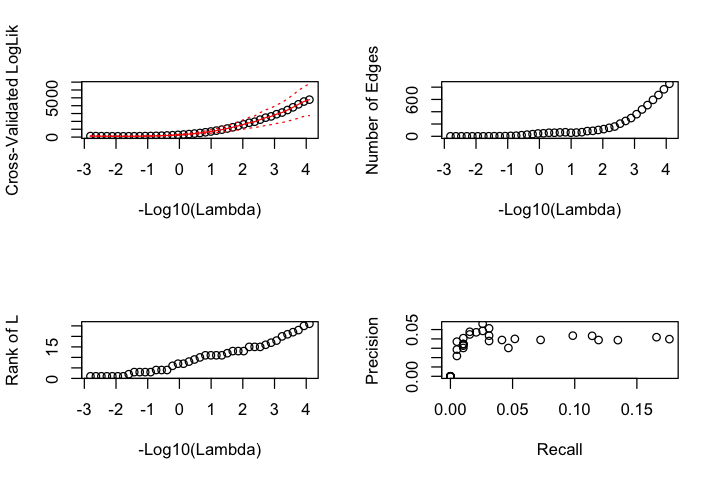

In [212]:
# Look at the path estimated with the sample covariance matrix
show.cross.validate.low.rank.plus.sparse(xval.path, ground.truth = true.S)

And now the path estimated when using the Kendall estimator:

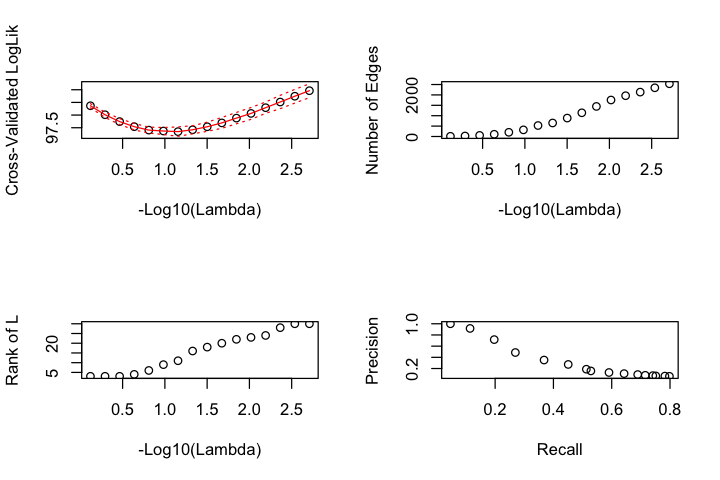

In [213]:
# Look at the path estimated with the Kendall estimator
show.cross.validate.low.rank.plus.sparse(Kendall.xval.path, ground.truth = true.S)